In [1]:
import pandas as pd
import numpy as np
import torch
import logging
import pathlib

In [2]:
path = pathlib.Path("../logs")
path.mkdir(exist_ok=True)

In [3]:
logging.basicConfig(format='%(asctime)s[%(levelname)s] %(funcName)s: %(message)s',
                           datefmt='%d/%m/%Y %I:%M:%S %p',
                           filename=path.joinpath("lstm.log"),
                           filemode='w')
logger = logging.getLogger(__name__)
logger.setLevel("INFO")

In [4]:
data = pd.read_csv("../data/featurized_dataset.csv")

In [5]:
timeseries = data[["Balance"]].values.astype("float32")

In [6]:
# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [8]:
lookback = 15
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1196, 15, 1]) torch.Size([1196, 15, 1])
torch.Size([288, 15, 1]) torch.Size([288, 15, 1])


/tmp/ipykernel_570162/844590115.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


In [9]:
import torch.nn as nn

class LightModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.9)
        self.linear = nn.Linear(32, 1)
    def forward(self, x, debug = False):
        x, _ = self.lstm(x)
        if debug:
          logger.info(x.shape)

        x = self.linear(x)
        return x

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [11]:
len(X_train)

1196

Будем считать градиенты по всему батчу -- с одной стороны это позволяет гарантировано сделать спуск именно спуском -- правда, есть больший, чем при стохастике шанс упереться в локальный минимум. Возможно, стоит запускать несколько раз и считать это также гиперпараметром

In [12]:
import torch.optim as optim
import torch.utils.data as data
from copy import deepcopy

model = LightModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                         batch_size=299, drop_last=True)

best_mae = np.inf

n_epochs = 2500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device), debug=False)
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device))
        train_mae = torch.max(np.abs(y_pred.cpu()[:, -1, :] - y_train[:, -1, :]), dim=0)[0].item()
        y_pred = model(X_test.to(device))
        test_mae = torch.max(np.abs(y_pred.cpu()[:, -1, :] - y_test[:, -1, :]), dim=0)[0].item()

        if test_mae < best_mae:
            best_model = deepcopy(model.state_dict())
        
    logger.info("Epoch %d: train MAXAE %.4f, test MAXAE %.4f" % (epoch, train_mae, test_mae))

logger.info("Loading best model...")
model.load_state_dict(best_model)

<All keys matched successfully>

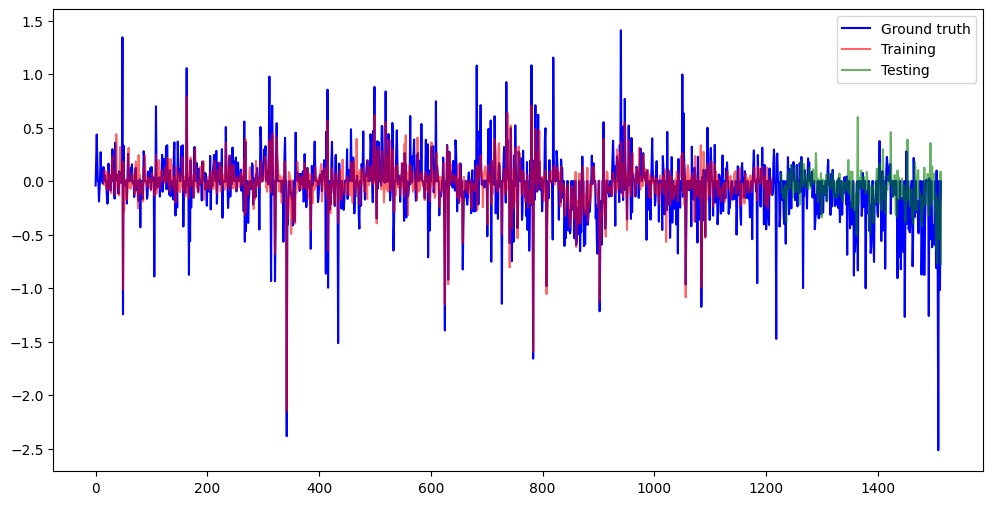

In [13]:
from matplotlib import pyplot as plt

model.to("cpu")

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.figure(figsize=(12, 6))
plt.plot(timeseries, c='b', label="Ground truth",)
plt.plot(train_plot, c='r', label="Training", alpha=0.6)
plt.plot(test_plot, c='g', label="Testing", alpha=0.6)
plt.legend()
plt.show()

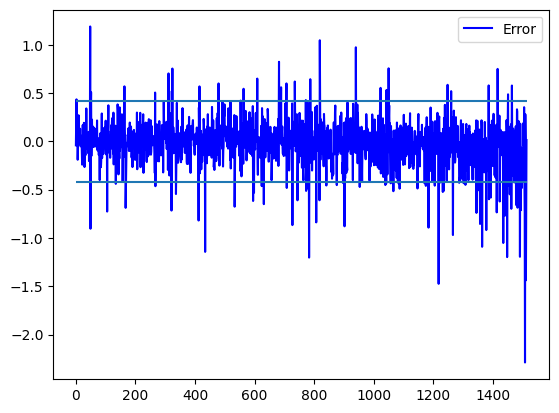

In [14]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.zeros_like(timeseries)
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.zeros_like(timeseries)
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

plt.plot(timeseries - train_plot - test_plot, c='b', label="Error")
plt.hlines(y = [-0.42, 0.42], xmin=0, xmax=len(timeseries))
plt.legend()
plt.show()

In [15]:
import pickle

model_file_path = '../model/lstm_model.pkl'

In [16]:
# Save the model to a file
pickle.dump(model, open(model_file_path, 'wb'))